In [1]:
from pathlib import PurePath
import os
import sys
os.chdir(PurePath(os.path.abspath('')).parent)
sys.path.append(os.getcwd())

In [2]:
import pandas as pd
import numpy as np

from split_utils import read_fasta, Identity, compute_identity_stats
import matplotlib.pyplot as plt

In [3]:
MIN_SEQ_LEN = 5
MAX_SEQ_LEN = 50

# Filter dataset

In [4]:
fasta = read_fasta("../data/build/dataset.fasta")
dataset = [(id_, seq) for id_, seq in fasta if MIN_SEQ_LEN <= len(seq) <= MAX_SEQ_LEN]
output_path = ".cache/mmseqs/dataset.fasta"
if not os.path.exists(PurePath(output_path).parent):
    os.makedirs(PurePath(output_path).parent)
with open(output_path, 'w') as f:
    for id_, seq in dataset:
        f.write(f">{id_}\n{seq}\n")
print(f"Filtered dataset saved to {output_path}")

Filtered dataset saved to .cache/mmseqs/dataset.fasta


# Cluster sequences using MMseqs2

In [5]:
!./mmseqs/cluster_mmseqs.sh

createdb .cache/mmseqs/dataset.fasta .cache/mmseqs/peptidesDB 

MMseqs Version:       	17.b804f
Database type         	0
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[17878] 0s 10ms
Time for merging to peptidesDB_h: 0h 0m 0s 4ms
Time for merging to peptidesDB: 0h 0m 0s 3ms
Database type: Aminoacid
Time for processing: 0h 0m 0s 33ms
Create directory .cache/mmseqs/tmp
linclust .cache/mmseqs/peptidesDB .cache/mmseqs/clusters .cache/mmseqs/tmp --min-seq-id 0.5 --cov-mode 0 -c 0. --cluster-mode 1 --kmer-per-seq 100000 --comp-bias-corr 0 

MMseqs Version:                     	17.b804f
Cluster mode                        	1
Max connected component depth       	1000
Similarity type                     	2
Threads                             	10
Compressed                          	0
Verbosity                           	3
Weight file name                    	
Cluster 

# Load clusters

In [6]:
clusters = pd.read_csv(".cache/mmseqs/clusters.tsv", sep="\t", header=None)
clusters.columns = ["reference_sequence_id", "sequence_id"]

# Split clusters into two sets

In [7]:
def split_clusters(clusters, test_ratio: float = 0.2):
    """
    Splits the clusters into training and test sets based on a given test ratio.
    :param clusters: The clusters DataFrame containing sequence IDs and their corresponding cluster IDs.
    :param test_ratio: The ratio of sequences to be included in the test set.
    :return: Two sets of ids, one for training and one for testing.
    """
    cluster_ids = clusters['reference_sequence_id'].unique()
    print("Found", len(cluster_ids), "clusters.")
    n_test = int(len(cluster_ids) * test_ratio) # Number of clusters to be used for testing
    test_clusters = set(cluster_ids[:n_test])
    train_clusters = set(cluster_ids[n_test:])
    train_ids = clusters[clusters['reference_sequence_id'].isin(train_clusters)]['sequence_id'].tolist()
    test_ids = clusters[clusters['reference_sequence_id'].isin(test_clusters)]['sequence_id'].tolist()
    return train_ids, test_ids

train_ids, test_ids = split_clusters(clusters)

Found 7687 clusters.


# Assert independence between training and test sets

In [8]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")

 100%|██████████████████████████████████████|  4574/4574 [10:59<00:00, 6.85it/s] 


In [9]:
test2train_id = identities.max(axis=1)

Max identity: 1.0
Mean identity: 0.7290310049867129
Median identity: 0.7777777777777778
Quantiles:
- 0.01 quantile: 0.354326375711575
- 0.05 quantile: 0.4166666666666667
- 0.10 quantile: 0.4583333333333333
- 0.25 quantile: 0.5882352941176471
- 0.50 quantile: 0.7777777777777778
- 0.75 quantile: 0.8823529411764706
- 0.90 quantile: 0.9166666666666666
- 0.95 quantile: 0.9285714285714286
- 0.99 quantile: 0.9473684210526315
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
4159


Text(0.5, 1.0, 'Highest identity between each test sequence and all train sequences')

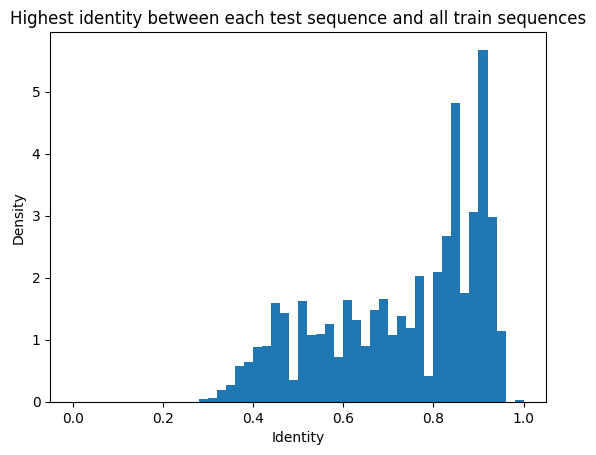

In [10]:
print(f"Max identity: {np.max(test2train_id)}")
print(f"Mean identity: {np.mean(test2train_id)}")
print(f"Median identity: {np.median(test2train_id)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(test2train_id, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(test2train_id, bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Highest identity between each test sequence and all train sequences")

Text(0.5, 1.0, 'Pairwise identity distribution between train and test')

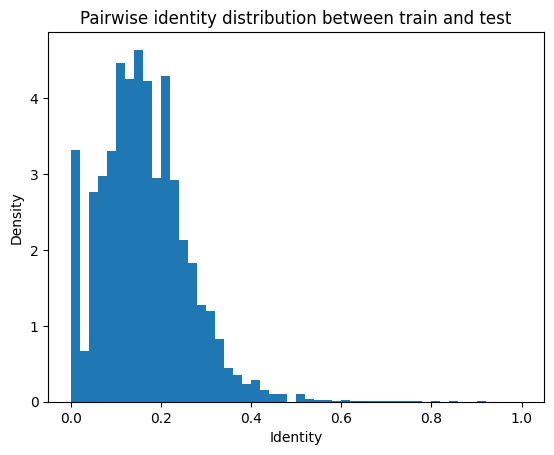

In [11]:
plt.hist(identities.reshape(-1), bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Pairwise identity distribution between train and test")

In [12]:
print(f"Length of train dataset: {len(train_ids)}")

Length of train dataset: 13361
